In [1]:
%matplotlib inline

In [2]:
qvarn = 'http://localhost:9001'
jsonb_91_no_alog = 'http://localhost:9002'
jsonb_91_alog = 'http://localhost:9003'
jsonb_92_no_alog = 'http://localhost:9004'
jsonb_92_alog = 'http://localhost:9005'
jsonb_95_alog = 'http://localhost:9006'
planb = 'http://localhost:9007'

names = {
    qvarn: 'qvarn',
    jsonb_91_no_alog: 'jsonb_91_no_alog',
    jsonb_91_alog: 'jsonb_91_alog',
    jsonb_92_no_alog: 'jsonb_92_no_alog',
    jsonb_92_alog: 'jsonb_92_alog',
    jsonb_95_alog: 'jsonb_95_alog',
    planb: 'planb',
}
backends = qvarn, jsonb_91_no_alog, jsonb_91_alog, jsonb_92_no_alog, jsonb_92_alog, jsonb_95_alog, planb

In [50]:
import collections
import configparser
import datetime
import faker
import hashlib
import itertools
import jwt
import logging as log
import os
import pandas as pd
import pathlib
import random
import requests
import seaborn as sns
import statistics
import sys
import time
import tqdm
import ujson as json
from IPython.display import display

log.basicConfig(filename='/tmp/performance-testing.log', level=log.DEBUG)
log.getLogger('urllib3').setLevel(log.ERROR)

sns.set(style="whitegrid", font_scale=2, rc={
    'figure.figsize': (16, 8),
})

claims = {
    'iss': 'https://auth-jsonb.alpha.vaultit.org',
    'sub': '',
    'aud': '',
    'exp': (datetime.datetime.now() + datetime.timedelta(days=10)).timestamp(),
    'scope': ' '.join([
        scope % resource_type
        for scope in (
            'uapi_%s_get',
            'uapi_%s_post',
            'uapi_%s_id_get',
            'uapi_%s_id_put',
            'uapi_%s_id_delete',
            'uapi_%s_search_id_get',
        )
        for resource_type in (
            'orgs',
            'access',
        )
    ]),
}
key = pathlib.Path('../keys/rsa').read_bytes()
token = jwt.encode(claims, key, algorithm='RS512').decode()

session = requests.Session()
session.headers['authorization'] = f'Bearer {token}'
session.headers['cache-control'] = 'no-cache'

fake = faker.Faker()

In [52]:
session.get(f'{qvarn}/version').json()

{
    'api': {'version': '0.82-6.vaultit'},
    'implementation': {'name': 'Qvarn', 'version': '0.82-6.vaultit'},
}

In [53]:
session.get(f'{jsonb_91_no_alog}/version').json()

{
    'api': {'version': '0.91+git'},
    'implementation': {'name': 'Qvarn', 'version': '0.91+git'},
}

In [54]:
session.get(f'{jsonb_91_alog}/version').json()

{
    'api': {'version': '0.91+git'},
    'implementation': {'name': 'Qvarn', 'version': '0.91+git'},
}

In [55]:
session.get(f'{jsonb_92_no_alog}/version').json()

{
    'api': {'version': '0.92'},
    'implementation': {'name': 'Qvarn', 'version': '0.92'},
}

In [56]:
session.get(f'{jsonb_92_alog}/version').json()

{
    'api': {'version': '0.92'},
    'implementation': {'name': 'Qvarn', 'version': '0.92'},
}

In [57]:
session.get(f'{jsonb_95_alog}/version').json()

{
    'api': {'version': '0.95+git'},
    'implementation': {'name': 'Qvarn', 'version': '0.95+git'},
}

In [58]:
session.get(f'{planb}/version').json()

{
    'api': {'version': '0.82-5.vaultit'},
    'implementation': {'name': 'Qvarn PlanB', 'version': '0.0.1'},
}

In [13]:
class Test:
    
    def __init__(self, n, backend, *args, **kwargs):
        self.backend = backend
        self.total = n
        self.prepare(*args, **kwargs)
        
    def prepare(self):
        pass
    
    def __iter__(self):
        yield from range(self.total)
            
    def __call__(self, item):
        raise NotImplementedError()

In [14]:
def stats_table(backends, counts, times, runs, failed):
    frame = pd.DataFrame(collections.OrderedDict([
        (('iterations', 'total'), [runs[x].total for x in backends]),
        (('iterations', 'failed'), [failed[x] for x in backends]),
        (('time in seconds', 'total'), [sum(times[x]) if times[x] else None for x in backends]),
        (('time in seconds', 'mean'), [statistics.mean(times[x]) if times[x] else None for x in backends]),
        (('time in seconds', 'median'), [statistics.median(times[x]) if times[x] else None for x in backends]),
        (('time in seconds', 'stdev'), [statistics.stdev(times[x]) if times[x] else None for x in backends]),
        (('', 'n resources'), [counts[x] for x in backends]),
    ]), index=[names[x] for x in backends])
    frame = frame.sort_values(('time in seconds', 'median'))
    median = frame[('time in seconds', 'median')]
    frame[('', 'n times slower')] = (median / median.min()).map('{:.1f}'.format)
    return frame

In [15]:
def violin_plot(backends, times, size):
    frame = pd.DataFrame(collections.OrderedDict([
        (names[x], times[x] + [None for i in range(size - len(times[x]))])
        for x in backends
    ]))
    ax = sns.violinplot(data=frame, orient='h')
    ax.set_xscale('log')
    ax.set_xlabel("time in seconds (log scale)")
    return ax

In [16]:
summary = pd.DataFrame({}, index=[names[x] for x in backends])

In [24]:
def measure(n, backends, test, *args, **kwargs):
    global summary
    
    counts = {
        x: len(session.get(f'{x}/orgs').json()['resources'])
        for x in backends
    }
    failed = {backend: 0 for backend in backends}
    times = collections.defaultdict(list)
    runs = {}
    for backend in backends:
        run = runs[backend] = test(n, backend, *args, **kwargs)
        name = names[backend]
        for item in tqdm.tqdm(run, name, total=run.total, leave=False):
            start = time.monotonic()
            try:
                resp = run(item)
            except KeyboardInterrupt:
                raise
            except:
                log.exception('error')
                ok = False
                resp = None
            else:
                ok = resp.ok
            delta = time.monotonic() - start
            if ok:
                times[backend].append(delta)
            else:
                if resp:
                    log.error('stauts: %d, response: %s', resp.status_code, resp.text)
                failed[backend] += 1
                
    frame = stats_table(backends, counts, times, runs, failed)
    display(frame)
    
    summary = pd.concat([summary, frame[('', 'n times slower')].astype(float)], axis=1, ignore_index=True)
    
    size = max(len(times[x]) for x in backends)
    if size > 1:
        ax = violin_plot(backends, times, size)
        display(ax)

In [18]:
def get_new_id(resource_type):
    type_field = hashlib.sha512(resource_type.encode()).hexdigest()[:4]
    random_field = os.urandom(16).hex()
    checksum_field = hashlib.sha512((type_field + random_field).encode()).hexdigest()[:8]
    return '-'.join([type_field, random_field, checksum_field])

get_new_id('org')

'f392-1804f13c2dc5aa40eaeb2c595d62440a-a9e95b56'

In [20]:
with open('orgs.jsonl', 'w') as f:
    for i in tqdm.tqdm(range(5_000)):
        org =  {
            'type': 'org',
            'country': 'FI',
            'names': (
                [fake.company(), fake.catch_phrase()]
                if random.randint(0, 50) == 42 else
                [fake.company()]
            ),
            'gov_org_ids': [
                {
                    'country': 'FI',
                    'org_id_type': 'registration_number',
                    'gov_org_id': fake.ssn(),
                }
            ],
            'contacts': [
                {
                    'contact_type': 'phone',
                    'phone_number': fake.phone_number(),
                    'full_address': fake.address(),
                    'contact_timestamp': str(time.time()),
                    'country': fake.country_code(),
                    'contact_roles': [],
                    'address_lines': fake.address().splitlines(),
                    'post_code': None,
                    'post_area': None,
                    'einvoice_operator': None,
                    'contact_source': 'qvarn-genarator',
                    'einvoice_address': None,
                    'email_address': None,
                }
                for i in range(random.randint(1, 5))
            ],
        }
        json.dump(org, f, ensure_ascii=False)
        f.write('\n')

100%|██████████| 5000/5000 [00:14<00:00, 334.71it/s]


In [21]:
def read_orgs():
    with open('orgs.jsonl') as f:
        yield from map(json.loads, f)
            
def gen_orgs(backends):
    return {backend: read_orgs() for backend in backends}
    
orgs = gen_orgs(backends)

In [35]:
def delete_orgs(backends):
    result = {}
    for backend in backends:
        success = failure = 0
        for resource in tqdm.tqdm(session.get(f'{backend}/orgs').json()['resources'], f'delete: {names[backend]}', leave=False):
            try:
                resp = session.delete(f'{backend}/orgs/{resource["id"]}')
            except requests.ConnectionError:
                log.exception('error while deleteing %s', resource['id'])
                failure += 1
            else:
                if resp.ok:
                    success += 1
                else:
                    failure += 1
        result[backend] = {'success': success, 'failure': failure}
    return result
            
            
def create_orgs(n, backends):
    result = {}
    for backend in backends:
        success = failure = 0
        for resource in tqdm.tqdm(itertools.islice(orgs[backend], n), f'create: {names[backend]}', total=n, leave=False):
            try:
                resp = session.post(f'{backend}/orgs', json=resource)
            except requests.ConnectionError:
                log.exception('error while creating resource')
                failure += 1
            else:
                if resp.ok:
                    success += 1
                else:
                    failure += 1
        result[backend] = {'success': success, 'failure': failure}
    return result
            

def reset(n, backends, delete=True):
    global orgs
    orgs = gen_orgs(backends)
    deleted = delete_orgs(backends) if delete else {x: {'success': 0, 'failure': 0} for x in backends}
    created = create_orgs(n, backends) if n > 0 else {x: {'success': 0, 'failure': 0} for x in backends}
    return pd.DataFrame(collections.OrderedDict([
        (('delete orgs', 'deleted'), [deleted[x]['success'] for x in backends]),
        (('delete orgs', 'failed'), [deleted[x]['failure'] for x in backends]),
        (('create orgs', 'created'), [created[x]['success'] for x in backends]),
        (('create orgs', 'failed'), [created[x]['failure'] for x in backends]),
        (('', 'orgs'), [len(session.get(f'{x}/orgs').json()['resources']) for x in backends]),
    ]), index=[names[x] for x in backends])
    
reset(0, backends)

delete orgs        create orgs            
                     deleted failed     created failed orgs
qvarn                      0      0           0      0    0
jsonb_91_no_alog           0      0           0      0    0
jsonb_91_alog              0      0           0      0    0
jsonb_92_no_alog           0      0           0      0    0
jsonb_92_alog              0      0           0      0    0
jsonb_95_alog              0      0           0      0    0
planb                      0      0           0      0    0

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        1.603452  0.016035  0.015527   
qvarn                   100      0        3.615411  0.036154  0.035283   
jsonb_91_no_alog        100      0        4.644863  0.046449  0.046942   
jsonb_92_no_alog        100      0        4.745208  0.047452  0.047783   
jsonb_92_alog           100      0        5.745463  0.057455  0.058033   
jsonb_91_alog           100      0        6.100351  0.061004  0.060554   
jsonb_95_alog           100      0       11.449487  0.114495  0.115969   

                                                       
                     stdev n resources n times slower  
planb             0.005187           0            1.0  
qvarn             0.007275           0            2.3  
jsonb_91_no_alog  0.005209           0            3.0  
jsonb_92_no_alog  0.009829           0            3.1  
jsonb_92_alog     0.005651           0            3.7  
jsonb_91_alog     0.007170           0            3.9  
jsonb_95_alog     0.005978           0            7.5

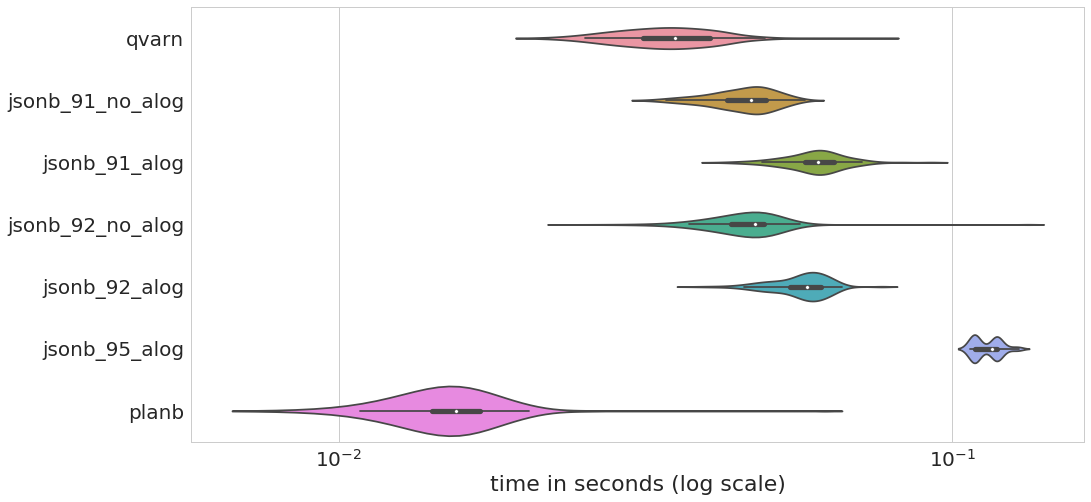

In [36]:
class CreateOrgs(Test):
    
    def __iter__(self):
        yield from itertools.islice(orgs[self.backend], self.total)
    
    def __call__(self, item):
        return session.post(f'{self.backend}/orgs', json=org)
    
measure(100, backends, CreateOrgs)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        2.047350  0.020474  0.020227   
qvarn                   100      1        3.975890  0.040161  0.039528   
jsonb_92_no_alog        100      0        4.118739  0.041187  0.040734   
jsonb_91_no_alog        100      0        4.312892  0.043129  0.042686   
jsonb_92_alog           100      0        5.217003  0.052170  0.051882   
jsonb_91_alog           100      0        5.941891  0.059419  0.058970   
jsonb_95_alog           100      0       13.951156  0.139512  0.139729   

                                                       
                     stdev n resources n times slower  
planb             0.003959         100            1.0  
qvarn             0.006172         100            2.0  
jsonb_92_no_alog  0.007827         100            2.0  
jsonb_91_no_alog  0.011194         100            2.1  
jsonb_92_alog     0.009251         100            2.6  
jsonb_91_alog     0.013567         100            2.9  
jsonb_95_alog     0.009963         100            6.9

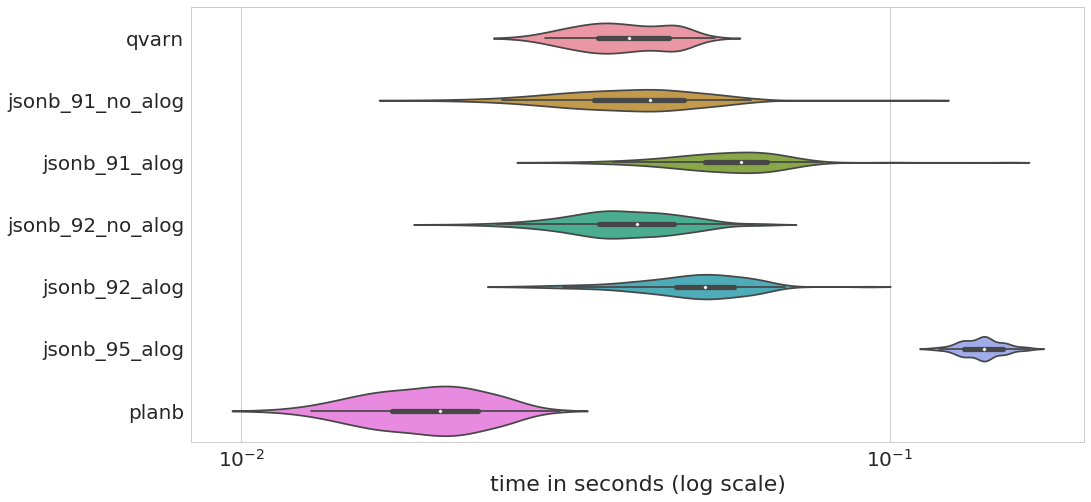

In [37]:
class UpdateOrgs(Test):
    
    def __iter__(self):
        for resource in session.get(f'{self.backend}/orgs').json()['resources'][:self.total]:
            try:
                yield session.get(f'{self.backend}/orgs/{resource["id"]}').json()
            except requests.ConnectionError:
                pass
        
    def __call__(self, resource):
        resource = dict(next(orgs[self.backend]), id=resource['id'], revision=resource['revision'])
        return session.put(f'{self.backend}/orgs/{resource["id"]}', json=resource)
    
measure(100, backends, UpdateOrgs)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        1.070894  0.010709  0.010381   
jsonb_92_no_alog        100      0        1.412079  0.014121  0.013825   
jsonb_91_no_alog        100      0        1.616915  0.016169  0.015583   
jsonb_92_alog           100      0        2.700431  0.027004  0.027258   
jsonb_91_alog           100      0        2.892697  0.028927  0.028390   
qvarn                   100      3        2.926910  0.030174  0.029603   
jsonb_95_alog           100      0       12.036930  0.120369  0.118623   

                                                       
                     stdev n resources n times slower  
planb             0.001785         100            1.0  
jsonb_92_no_alog  0.002523         100            1.3  
jsonb_91_no_alog  0.003322         100            1.5  
jsonb_92_alog     0.003910         100            2.6  
jsonb_91_alog     0.004483         100            2.7  
qvarn             0.005326         100            2.9  
jsonb_95_alog     0.006889         100           11.4

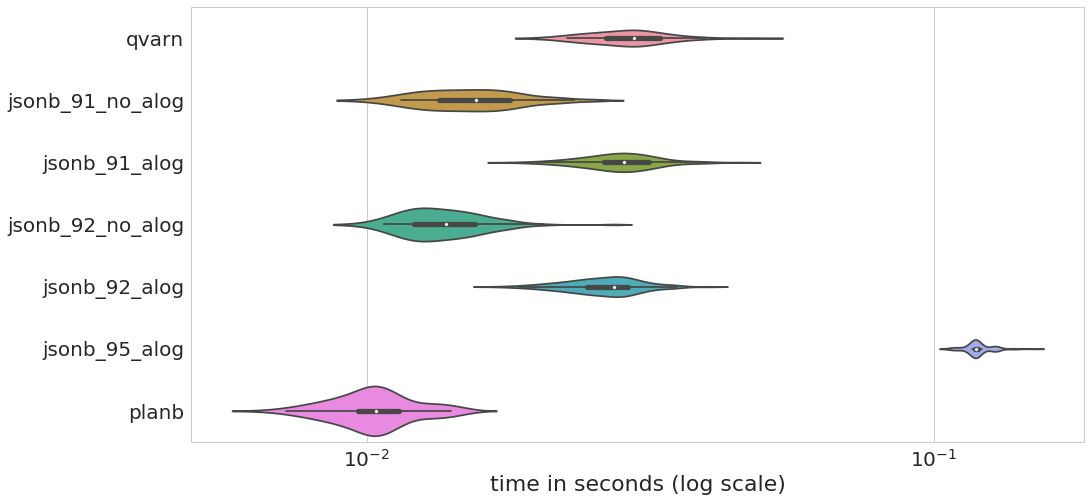

In [38]:
class DeleteResources(Test):
    
    def prepare(self, resource_type):
        self.resource_type = resource_type
        self.resp = session.get(f'{self.backend}/{resource_type}').json()
        self.total = len(self.resp['resources'])
        
    def __iter__(self):
        yield from iter(self.resp['resources'])
            
    def __call__(self, resource):
        return session.delete(f'{self.backend}/{self.resource_type}/{resource["id"]}')

measure(None, backends, DeleteResources, 'orgs')

In [39]:
reset(100, backends)

delete orgs        create orgs            
                     deleted failed     created failed orgs
qvarn                      3      0         100      0  100
jsonb_91_no_alog           0      0         100      0  100
jsonb_91_alog              0      0         100      0  100
jsonb_92_no_alog           0      0         100      0  100
jsonb_92_alog              0      0         100      0  100
jsonb_95_alog              0      0         100      0  100
planb                      0      0         100      0  100

iterations        time in seconds                      \
                      total failed           total      mean    median   
qvarn                   100      0        1.124337  0.011243  0.011210   
planb                   100      0        1.165167  0.011652  0.011514   
jsonb_92_no_alog        100      0        3.392820  0.033928  0.033629   
jsonb_91_no_alog        100      0        3.569830  0.035698  0.036301   
jsonb_92_alog           100      0       13.688028  0.136880  0.139794   
jsonb_95_alog           100      0       23.886351  0.238864  0.242315   
jsonb_91_alog           100      0      128.564650  1.285647  1.286700   

                                                       
                     stdev n resources n times slower  
qvarn             0.002354         100            1.0  
planb             0.002187         100            1.0  
jsonb_92_no_alog  0.005017         100            3.0  
jsonb_91_no_alog  0.006413         100            3.2  
jsonb_92_alog     0.017866         100           12.5  
jsonb_95_alog     0.021754         100           21.6  
jsonb_91_alog     0.052842         100          114.8

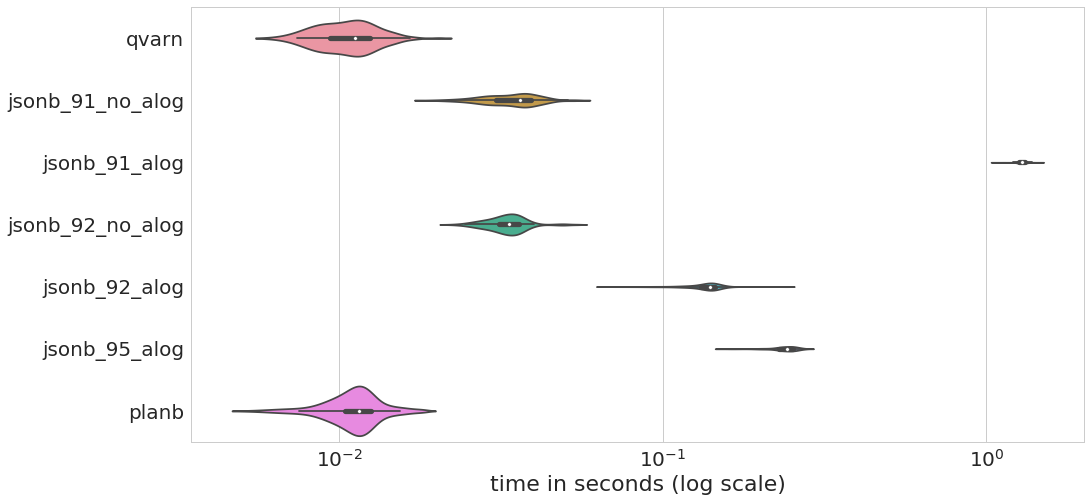

In [40]:
class GetAll(Test):
    
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs')
    
measure(100, backends, GetAll)

In [41]:
pd.DataFrame(collections.OrderedDict([
    (names[backend], len(session.get(f'{backend}/access').json()['resources']))
    for backend in backends
]), index=['number of access log entries']).T

,number of access log entries
qvarn,0
jsonb_91_no_alog,0
jsonb_91_alog,11100
jsonb_92_no_alog,0
jsonb_92_alog,822
jsonb_95_alog,822
planb,0


iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        3.311498  0.033115  0.032184   
jsonb_92_no_alog        100      0       24.552929  0.245529  0.245585   
jsonb_91_no_alog        100      0       33.900349  0.339003  0.340367   
jsonb_92_alog           100      0       34.833959  0.348340  0.352214   
qvarn                   100      0      102.574328  1.025743  1.030628   
jsonb_95_alog           100      0      140.883300  1.408833  1.419747   
jsonb_91_alog           100      0      164.134491  1.641345  1.644035   

                                                       
                     stdev n resources n times slower  
planb             0.008431         100            1.0  
jsonb_92_no_alog  0.025763         100            7.6  
jsonb_91_no_alog  0.025702         100           10.6  
jsonb_92_alog     0.029381         100           10.9  
qvarn             0.040820         100           32.0  
jsonb_95_alog     0.113140         100           44.1  
jsonb_91_alog     0.065707         100           51.1

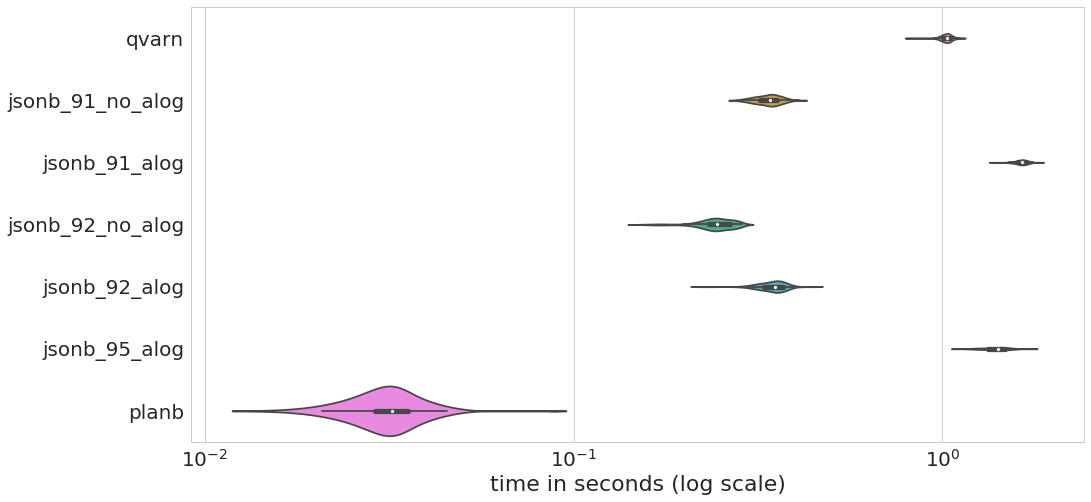

In [42]:
class SearchShowAll(Test):
    
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/show_all')

measure(100, backends, SearchShowAll)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        2.618102  0.026181  0.026080   
qvarn                   100      0       18.670063  0.186701  0.186476   
jsonb_92_no_alog        100      0       24.305552  0.243056  0.245496   
jsonb_91_no_alog        100      0       28.745273  0.287453  0.285193   
jsonb_92_alog           100      0       32.671405  0.326714  0.324477   
jsonb_91_alog           100      0      155.238855  1.552389  1.564857   
jsonb_95_alog           100      0      167.642781  1.676428  1.656175   

                                                       
                     stdev n resources n times slower  
planb             0.005071         100            1.0  
qvarn             0.019362         100            7.2  
jsonb_92_no_alog  0.019658         100            9.4  
jsonb_91_no_alog  0.025986         100           10.9  
jsonb_92_alog     0.026517         100           12.4  
jsonb_91_alog     0.060759         100           60.0  
jsonb_95_alog     0.135796         100           63.5

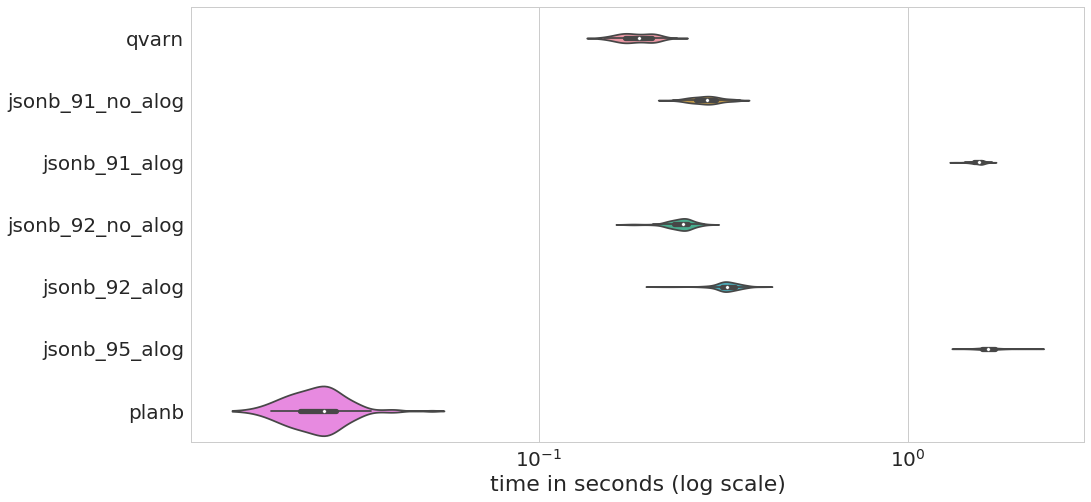

In [43]:
class SearchShow(Test):
    
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/show/names')

measure(100, backends, SearchShow)

In [61]:
reset(1000, backends, delete=False)

delete orgs        create orgs             
                     deleted failed     created failed  orgs
qvarn                      0      0         996      4   996
jsonb_91_no_alog           0      0        1000      0  1000
jsonb_91_alog              0      0        1000      0  1000
jsonb_92_no_alog           0      0        1000      0  1000
jsonb_92_alog              0      0        1000      0  1000
jsonb_95_alog              0      0        1000      0  1000
planb                      0      0        1000      0  1000

iterations        time in seconds                        \
                      total failed           total       mean     median   
qvarn                    10      0        0.206540   0.020654   0.019906   
planb                    10      0        0.373835   0.037384   0.037534   
jsonb_91_no_alog         10      0        2.292584   0.229258   0.221786   
jsonb_92_no_alog         10      0        2.234740   0.223474   0.228012   
jsonb_92_alog            10      0       12.296993   1.229699   1.219180   
jsonb_95_alog            10      0       28.015000   2.801500   2.794996   
jsonb_91_alog            10      0      141.659582  14.165958  14.250911   

                                                       
                     stdev n resources n times slower  
qvarn             0.005370        1099            1.0  
planb             0.008941        1100            1.9  
jsonb_91_no_alog  0.036784        1100           11.1  
jsonb_92_no_alog  0.018208        1100           11.5  
jsonb_92_alog     0.052525        1100           61.2  
jsonb_95_alog     0.082031        1100          140.4  
jsonb_91_alog     0.262124        1100          715.9

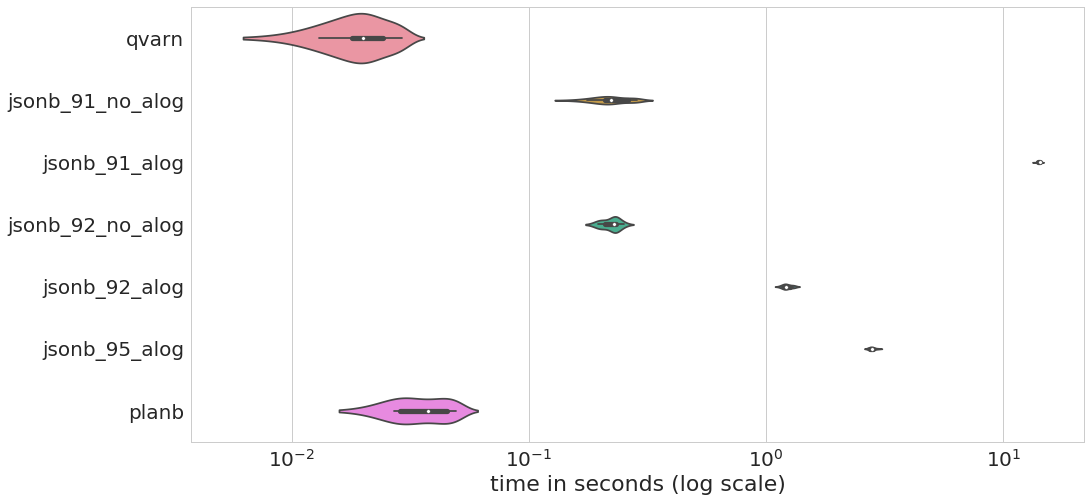

In [45]:
measure(10, backends, GetAll)

iterations        time in seconds                        \
                      total failed           total       mean     median   
planb                    10      0        0.086735   0.008673   0.007081   
qvarn                    10      0        0.211761   0.021176   0.021483   
jsonb_92_alog            10      0       22.354166   2.235417   2.219824   
jsonb_92_no_alog         10      0       22.262414   2.226241   2.231823   
jsonb_91_alog            10      0       27.936335   2.793634   2.810097   
jsonb_91_no_alog         10      0       28.255404   2.825540   2.839425   
jsonb_95_alog            10      0      163.142620  16.314262  16.358375   

                                                       
                     stdev n resources n times slower  
planb             0.004395        1000            1.0  
qvarn             0.003447         996            3.0  
jsonb_92_alog     0.067387        1000          313.5  
jsonb_92_no_alog  0.044255        1000          315.2  
jsonb_91_alog     0.055949        1000          396.9  
jsonb_91_no_alog  0.079699        1000          401.0  
jsonb_95_alog     0.190031        1000         2310.3

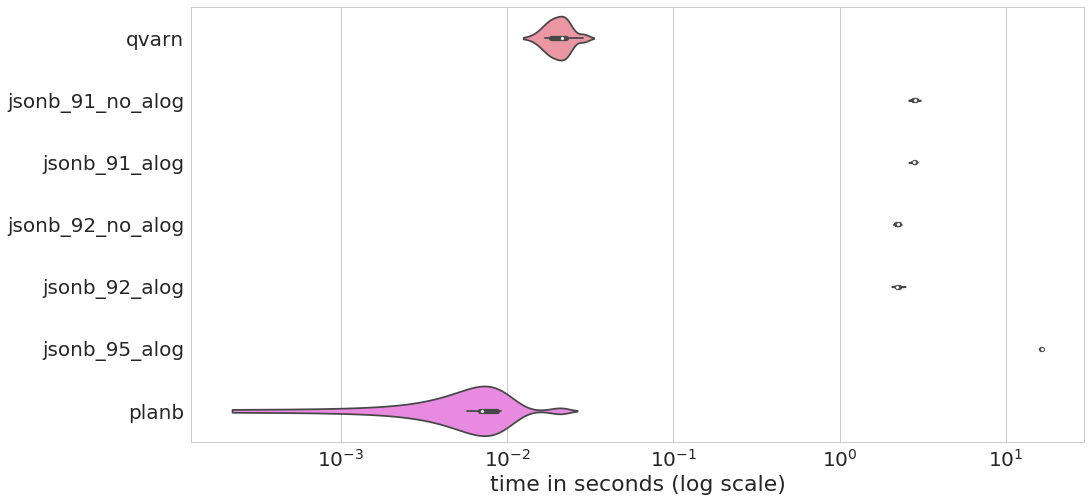

In [62]:
class SearchLimit(Test):
    
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/sort/id/limit/1')
    
measure(10, backends, SearchLimit)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                  1000      0        8.393381  0.008393  0.008296   
jsonb_92_no_alog       1000      0       10.124965  0.010125  0.009898   
jsonb_91_no_alog       1000      0       10.580091  0.010580  0.010449   
jsonb_92_alog          1000      0       23.526949  0.023527  0.023368   
jsonb_91_alog          1000      0       24.169526  0.024170  0.023959   
qvarn                  1000      1       30.884304  0.030915  0.030439   
jsonb_95_alog          1000      0       86.554161  0.086554  0.088499   

                                                       
                     stdev n resources n times slower  
planb             0.001651        1000            1.0  
jsonb_92_no_alog  0.001656        1000            1.2  
jsonb_91_no_alog  0.001625        1000            1.3  
jsonb_92_alog     0.003185        1000            2.8  
jsonb_91_alog     0.003428        1000            2.9  
qvarn             0.007700         996            3.7  
jsonb_95_alog     0.007115        1000           10.7

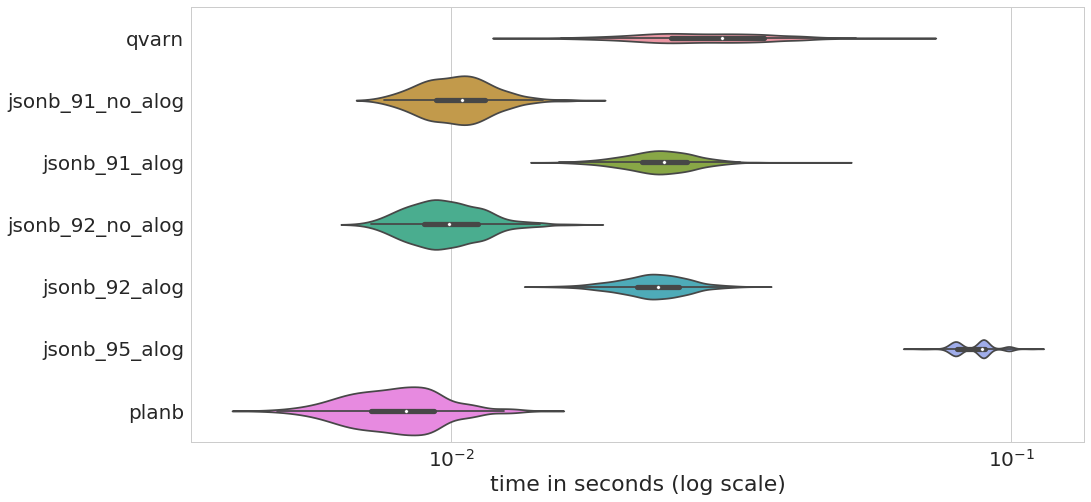

In [63]:
class GetOne(Test):
    
    def prepare(self):
        self.resources = [
            resource['id'] for resource in session.get(f'{self.backend}/orgs').json()['resources']
        ]
        
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/{random.choice(self.resources)}')
    
measure(1000, backends, GetOne)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        0.885466  0.008855  0.008555   
jsonb_92_no_alog        100      0        1.347293  0.013473  0.013021   
jsonb_91_no_alog        100      0        1.454338  0.014543  0.014330   
qvarn                   100      0        1.868116  0.018681  0.018290   
jsonb_91_alog           100      0        2.578424  0.025784  0.025633   
jsonb_92_alog           100      0        2.621911  0.026219  0.026153   
jsonb_95_alog           100      0        9.913009  0.099130  0.099466   

                                                       
                     stdev n resources n times slower  
planb             0.001631        1000            1.0  
jsonb_92_no_alog  0.002513        1000            1.5  
jsonb_91_no_alog  0.002230        1000            1.7  
qvarn             0.002637         996            2.1  
jsonb_91_alog     0.004156        1000            3.0  
jsonb_92_alog     0.003309        1000            3.1  
jsonb_95_alog     0.006801        1000           11.6

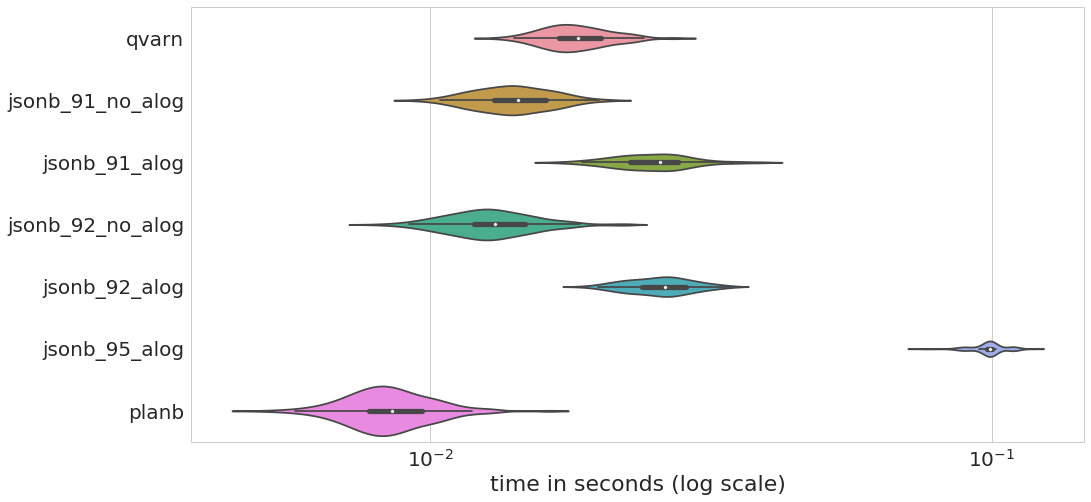

In [64]:
class SearchExact(Test):
    
    def prepare(self):
        self.gov_org_ids = [
            resource['gov_org_ids'][0]['gov_org_id'] for resource in (
                session.get(f'{self.backend}/orgs/search/show/gov_org_ids').
                json()['resources']
            )
        ]
        
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/exact/gov_org_id/{random.choice(self.gov_org_ids)}')
    
measure(100, backends, SearchExact)

iterations        time in seconds                      \
                      total failed           total      mean    median   
planb                   100      0        1.572195  0.015722  0.015390   
qvarn                   100      0        2.018544  0.020185  0.019772   
jsonb_91_no_alog        100      0        3.270904  0.032709  0.029551   
jsonb_92_no_alog        100      0        3.155903  0.031559  0.031035   
jsonb_92_alog           100      0        6.316739  0.063167  0.062627   
jsonb_91_alog           100      0        9.331586  0.093316  0.092694   
jsonb_95_alog           100      0       14.479315  0.144793  0.148605   

                                                       
                     stdev n resources n times slower  
planb             0.002333        1000            1.0  
qvarn             0.004123         996            1.3  
jsonb_91_no_alog  0.007174        1000            1.9  
jsonb_92_no_alog  0.004699        1000            2.0  
jsonb_92_alog     0.009122        1000            4.1  
jsonb_91_alog     0.010815        1000            6.0  
jsonb_95_alog     0.013811        1000            9.7

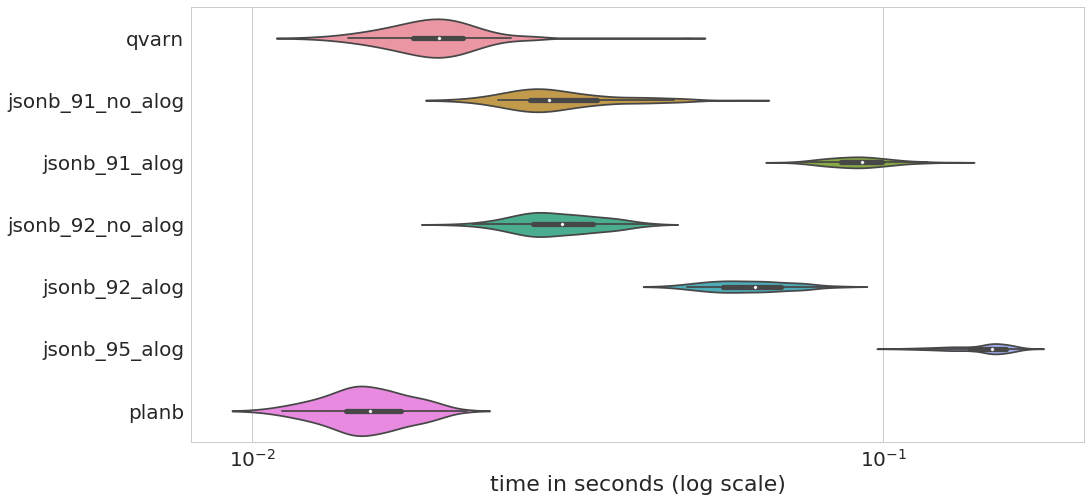

In [65]:
class SearchStartswith(Test):
    
    def prepare(self):
        self.gov_org_ids = [
            resource['gov_org_ids'][0]['gov_org_id'] for resource in (
                session.get(f'{self.backend}/orgs/search/show/gov_org_ids').
                json()['resources']
            )
        ]
        
    def __call__(self, item):
        return session.get(f'{self.backend}/orgs/search/startswith/gov_org_id/{random.choice(self.gov_org_ids)}')
    
measure(100, backends, SearchStartswith)

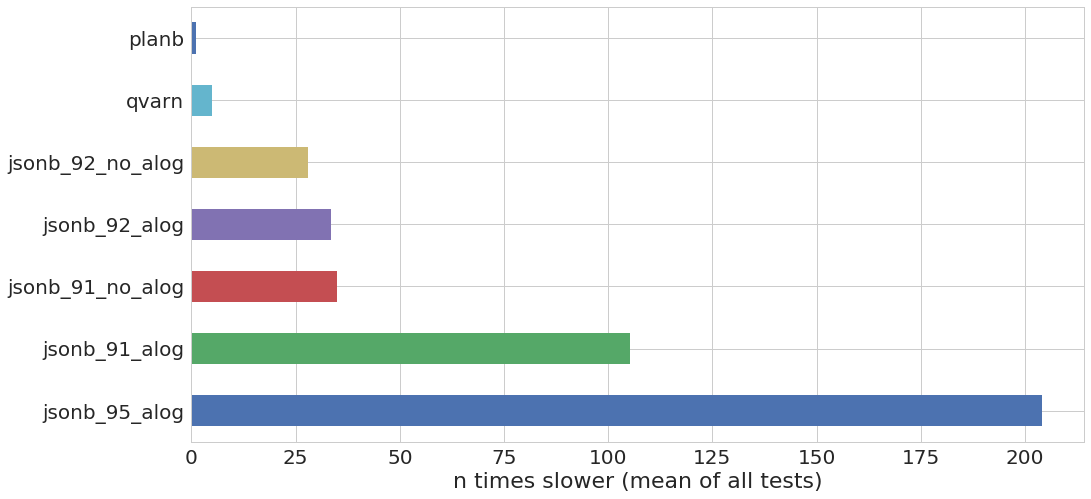

In [73]:
ax = summary.mean(axis=1).sort_values(ascending=False).plot.barh()
ax.set_xlabel('n times slower (mean of all tests)');

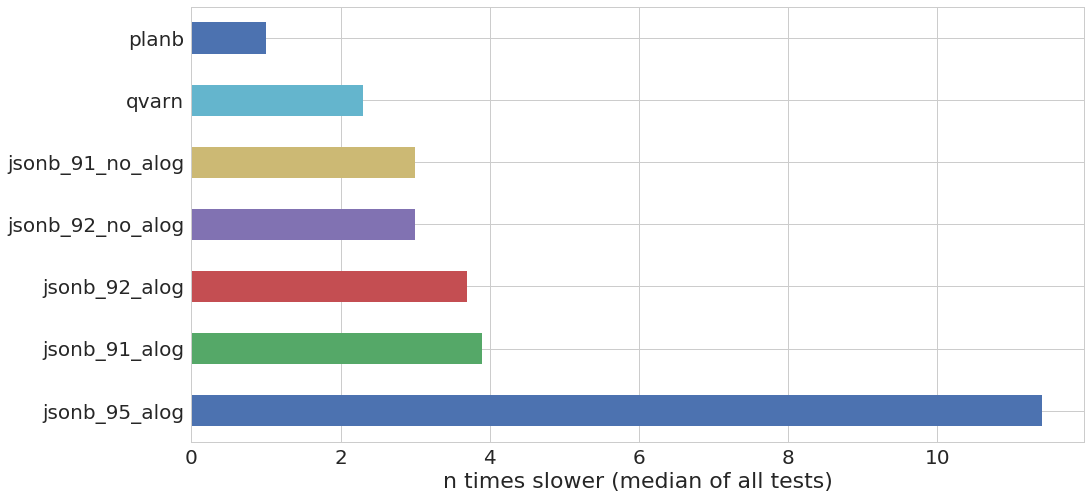

In [74]:
ax = summary.median(axis=1).sort_values(ascending=False).plot.barh()
ax.set_xlabel('n times slower (median of all tests)');

In [75]:
summary

,0,1,2,3,4,5,6,7,8,12,13,14,15
jsonb_91_alog,3.9,3.9,3.9,2.9,2.7,114.8,51.1,60.0,715.9,396.9,2.9,3.0,6.0
jsonb_91_no_alog,3.0,3.1,3.0,2.1,1.5,3.2,10.6,10.9,11.1,401.0,1.3,1.7,1.9
jsonb_92_alog,3.6,3.6,3.7,2.6,2.6,12.5,10.9,12.4,61.2,313.5,2.8,3.1,4.1
jsonb_92_no_alog,3.0,3.0,3.1,2.0,1.3,3.0,7.6,9.4,11.5,315.2,1.2,1.5,2.0
jsonb_95_alog,7.3,7.3,7.5,6.9,11.4,21.6,44.1,63.5,140.4,2310.3,10.7,11.6,9.7
planb,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.9,1.0,1.0,1.0,1.0
qvarn,2.3,2.3,2.3,2.0,2.9,1.0,32.0,7.2,1.0,3.0,3.7,2.1,1.3
